In [26]:
import os
import csv
from collections import defaultdict
import shutil
import random
import os
from PIL import Image, ImageEnhance
import os
import imghdr
import random

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import VGG16, ResNet101, ResNet152
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryCrossentropy, FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

import os
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [27]:
# function that takes a model name and applies it (only necessary when applying multiple models)

def get_callbacks(model_name):
    # Use Kaggle's working directory and update the extension to .keras
    filepath = os.path.join("/kaggle/working", f'model.{model_name}.keras')

    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    # naming the model
    callbacks.append(checkpoint)

    anne = ReduceLROnPlateau(factor=0.5, patience=10, verbose=1, min_lr=0.0000001)
    # if after 10 times and there is no improvement in val_loss, decrease lr by 50%
    callbacks.append(anne)

    earlystop = EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor="val_accuracy")
    # if after 5 times there is no improvement, stop
    callbacks.append(earlystop)

    return callbacks

print("ok")

ok


In [1]:
train_path = "/kaggle/input/train-test-emb2/train/train/train"
test_path = "/kaggle/input/train-test-emb2/test/test"
image_size = (224, 224) # the model requires this
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.20, # split 20%
    subset = "training", # this means that this subset that we're talking is for training (80%)
    seed = 1337, # so the splitting isn't random each time
    image_size = image_size,
    batch_size = batch_size,
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split = 0.20, # split 20%
    subset = "validation", # this means that this subset that we're talking is for validation (20%)
    seed = 1337, # so the splitting isn't random each time
    image_size = image_size,
    batch_size = batch_size,
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False, # really important for testing
)

# the output means: 2596 training, 649 validation, 812 testing

Found 3245 files belonging to 2 classes.
Using 2596 files for training.
Found 3245 files belonging to 2 classes.
Using 649 files for validation.
Found 812 files belonging to 2 classes.


In [29]:
# test_df returns both X and Y
# we want this Y which we will call "y_true": y_true refers to the true labels in test
# we need to save them in a variable to compare with y_pred after testing

y_true = np.concatenate([y for x,y in test_df], axis=0)

In [30]:
# hyperparameters

IMG_IND = 224 # size
IMG_SHAPE = (IMG_IND, IMG_IND, 3)
LOSS = BinaryCrossentropy() # because this is a binary calsssifation problem
IMG_SIZE = (224, 224)
SEED = 2
BATCH_SIZE = 32

In [31]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2

# Define the optimizer
OPTIMIZER = RMSprop(learning_rate=0.005, rho=0.9) #rho is decay rate

# Load base model
base_model = ResNet101(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False

x = base_model.output

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid', name='Final')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


In [32]:
print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 43,946,177 (167.64 MB)

 Trainable params: 1,285,633 (4.90 MB)

 Non-trainable params: 42,660,544 (162.74 MB)

None


In [33]:
callbacks = get_callbacks('resnet101') # calling the function i made earlier

history = model.fit(train_df, epochs=20, validation_data=val_df, callbacks=[callbacks])

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_df)

Epoch 1/50
 1/76 ━━━━━━━━━━━━━━━━━━━━ 32:49 26s/step - accuracy: 0.5000 - loss: 0.7082

W0000 00:00:1719591885.910487      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8099 - loss: 0.3883

W0000 00:00:1719591907.346683      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719591914.354692      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to /kaggle/working/model.resnet101.keras


W0000 00:00:1719591919.833265      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 62s 478ms/step - accuracy: 0.8105 - loss: 0.3874 - val_accuracy: 0.8640 - val_loss: 1.1427 - learning_rate: 0.0050
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9097 - loss: 0.2243
Epoch 2: saving model to /kaggle/working/model.resnet101.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.9096 - loss: 0.2243 - val_accuracy: 0.9171 - val_loss: 0.2739 - learning_rate: 0.0050
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9150 - loss: 0.1977
Epoch 3: saving model to /kaggle/working/model.resnet101.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9150 - loss: 0.1977 - val_accuracy: 0.9204 - val_loss: 0.2225 - learning_rate: 0.0050
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9174 - loss: 0.1928
Epoch 4: saving model to /kaggle/working/model.resnet101.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.9175 - loss: 0.1927 - val_accuracy: 0.9022 - val_loss: 0.2261 - learnin

W0000 00:00:1719592198.323206      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 0.9343971610069275


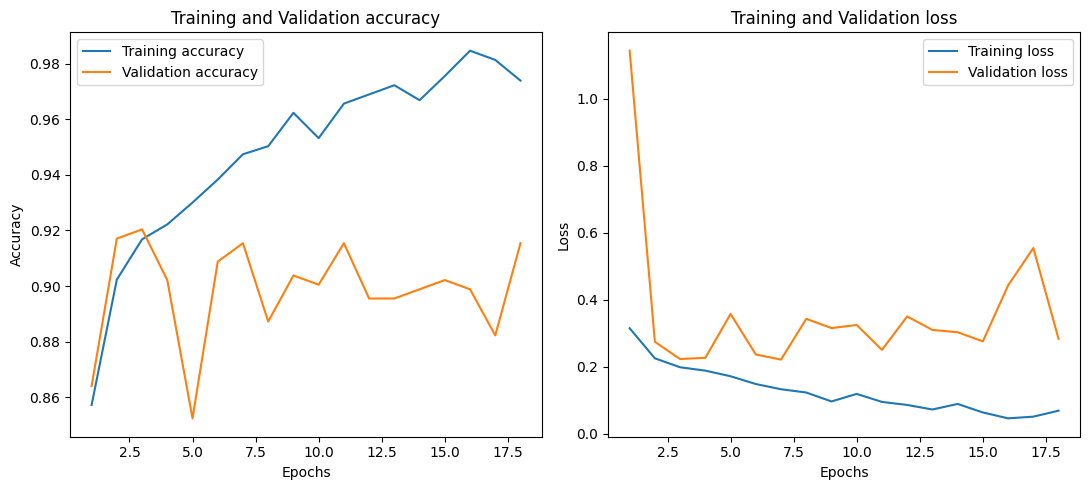

In [34]:
# Print the test accuracy
print(f"Test Accuracy: {test_accuracy}")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Train and validation accuracy
ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Train and validation loss
ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step

W0000 00:00:1719592206.901549      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 526ms/step


W0000 00:00:1719592215.845815      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


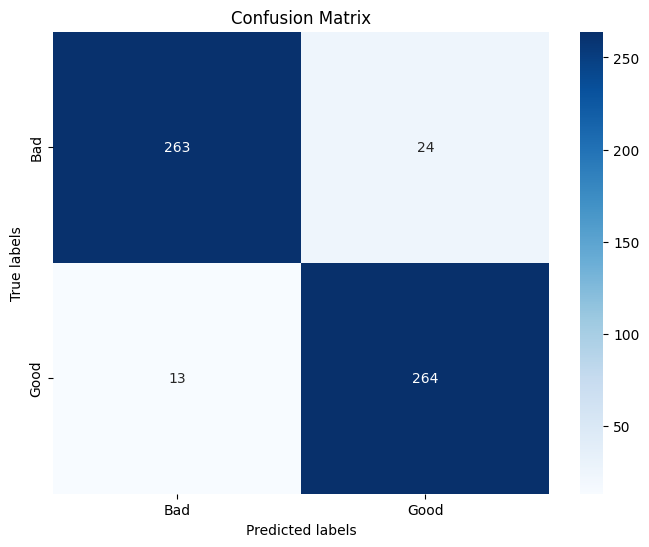

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       287
           1       0.92      0.95      0.93       277

    accuracy                           0.93       564
   macro avg       0.93      0.93      0.93       564
weighted avg       0.94      0.93      0.93       564



In [35]:
# Make predictions on the test data
import seaborn as sns
predictions = model.predict(test_df)
predictions_binary = np.round(predictions).flatten()

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, predictions_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, predictions_binary))


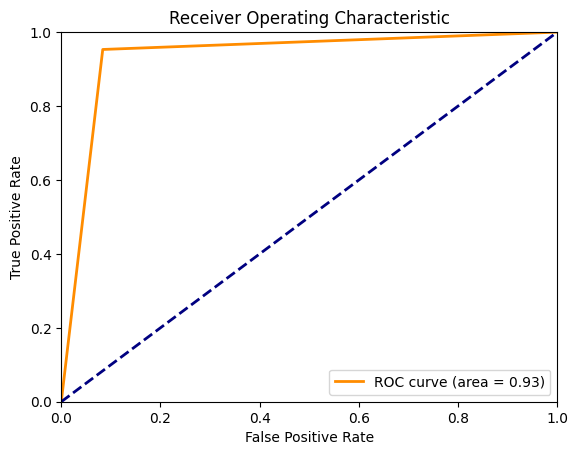

0.9347224493389854


In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assume y_true is the true binary labels and y_scores are the predicted scores/probabilities
fpr, tpr, thresholds = roc_curve(y_true, predictions_binary)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)